In [27]:
import pykoop
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.linalg import eig
import seaborn as sns
import sklearn
from scipy import stats
from itertools import combinations  # 用于生成两两组合
import warnings
from res_tool import compute_koopman_matrices,compute_edmd_eigenpairs,compute_residual
from res_tool import plot_clustered_kuramoto

from numpy.polynomial.legendre import Legendre
from scipy.special import legendre 
from scipy.integrate import fixed_quad 
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh

In [28]:
def koop_pseudo_spec(G, A, L, z_pts, **kwargs):
    """
    计算K的伪谱
    
    Parameters:
    G: Gram矩阵<psi_j, psi_i>
    A: 第一个Galerkin矩阵 <K psi_j, psi_i>
    L: 第二个Galerkin矩阵 <K psi_j, K psi_i>
    z_pts: 复数点向量，用于计算伪谱
    
    Optional:
    reg_param: G的正则化参数
    
    Returns:
    RES: z_pts处的残差
    """
    # 解析可选参数
    reg_param = kwargs.get('reg_param', 1e-14)
    
    # 确保矩阵是Hermitian的
    G = (G + G.T.conj()) / 2
    L = (L + L.T.conj()) / 2
    
    # 正则化G并计算SQ矩阵
    G_reg = G + np.linalg.norm(G) * reg_param * np.eye(G.shape[0])
    w, V = eigh(G_reg)
    
    # 避免除零和负值
    w = np.maximum(w, 1e-15)
    w_sqrt = np.sqrt(1.0 / np.abs(w))
    SQ = V @ np.diag(w_sqrt) @ V.T.conj()
    
    z_pts = z_pts.flatten()
    LL = len(z_pts)
    RES = np.zeros(LL, dtype=float)
    
    if LL > 0:
        warnings.filterwarnings('ignore', category=UserWarning)
        
        for jj in range(LL):
            z = z_pts[jj]
            try:
                # 构造该z对应的矩阵
                M_z = (L - z * A.T.conj() - np.conj(z) * A + (np.abs(z)**2) * G)
                M_transformed = SQ @ M_z @ SQ
                
                # 确保矩阵是Hermitian的以用于eigvalsh
                M_transformed = (M_transformed + M_transformed.T.conj()) / 2
                
                # 使用稠密计算找到最小特征值（更稳定）
                eigvals = np.linalg.eigvalsh(M_transformed)
                min_eigval = np.min(np.real(eigvals))
                
                # 避免由于数值误差导致的负值
                RES[jj] = np.sqrt(max(0, min_eigval))
                
            except Exception as e:
                print(f"Warning: Error at z={z}: {e}")
                RES[jj] = np.nan
    
    warnings.resetwarnings()
    
    return RES

In [29]:
def plot_pseudospectra(G, A, L, eigenvalues, eigenvectors, step=0.05, residual_threshold=0.01, padding_ratio=0.2, fixed_range=None):
    """
    绘制伪谱图，并根据残差阈值区分可靠和虚假特征值

    Parameters:
    G, A, L: Koopman矩阵
    x_range, y_range: 绘图范围
    step: 网格步长
    residual_threshold: 算法2中的残差阈值ε
    padding_ratio: 在特征值范围基础上添加的边距比例
    fixed_range: 如果提供，则使用固定的绘图范围 (x_min, x_max, y_min, y_max)
    """
    # 1. 计算EDMD特征对 (算法2步骤2)
    #eigenvalues, eigenvectors = eig(A, G)
    # 特征向量在矩阵eigenvectors的列中

    # 2. 为每个特征对计算残差 (算法2步骤3的逻辑)
    residuals = []
    reliable_indices = []
    spurious_indices = []

    for i in range(len(eigenvalues)):
        lambda_i = eigenvalues[i]
        g_i = eigenvectors[:, i]
        res_i = compute_residual(lambda_i, g_i, G, A, L)
        residuals.append(res_i)

        if res_i <= residual_threshold:
            reliable_indices.append(i)
        else:
            spurious_indices.append(i)

    print(f"总特征值数量: {len(eigenvalues)}")
    print(f"可靠特征值数量 (res <= {residual_threshold}): {len(reliable_indices),reliable_indices}")
    print(f"虚假特征值数量 (res > {residual_threshold}): {len(spurious_indices)}")

    # 3. 确定绘图范围
    if fixed_range is not None:
        # 使用固定的绘图范围
        x_range = (fixed_range[0], fixed_range[1])
        y_range = (fixed_range[2], fixed_range[3])
    else:
        # 自适应范围：基于所有特征值的分布
        real_parts = np.real(eigenvalues)
        imag_parts = np.imag(eigenvalues)
        
        # 计算特征值的范围
        real_min, real_max = np.min(real_parts), np.max(real_parts)
        imag_min, imag_max = np.min(imag_parts), np.max(imag_parts)
        
        # 使用相同的范围，保持纵横比一致
        overall_min = min(real_min, imag_min)
        overall_max = max(real_max, imag_max)
        overall_range = overall_max - overall_min
        
        # 如果范围太小（如所有特征值都集中在一点），设置最小范围
        if overall_range < 0.1:
            overall_range = 1.0
            center = (overall_min + overall_max) / 2
            overall_min = center - 0.5
            overall_max = center + 0.5
        
        # 添加边距
        padding = overall_range * padding_ratio
        x_range = (overall_min - padding, overall_max + padding)
        y_range = (overall_min - padding, overall_max + padding)
    
    # 3. 计算伪谱网格（算法3/原有伪谱计算逻辑）
    x_pts = np.arange(x_range[0], x_range[1] + step, step)
    y_pts = np.arange(y_range[0], y_range[1] + step, step)
    X_grid, Y_grid = np.meshgrid(x_pts, y_pts)
    z_pts = X_grid + 1j * Y_grid
    z_flat = z_pts.flatten()

    RES = koop_pseudo_spec(G, A, L, z_flat)
    RES = RES.reshape(z_pts.shape)
    RES = np.nan_to_num(RES, nan=np.max(RES[~np.isnan(RES)]))

    # 4. 绘图
    plt.figure(figsize=(8, 8))

    # 伪谱等高线
    levels = [0.001, 0.01, 0.1, 0.3]
    contour = plt.contour(X_grid, Y_grid, np.real(RES), levels=levels,
                         colors='black', linewidths=2)
    plt.clabel(contour, inline=True, fontsize=11, fmt='%.3f')

    # 绘制特征值
    # 可靠特征值 (残差小) - 蓝色十字
    reliable_eigs = eigenvalues[reliable_indices]
    plt.plot(np.real(reliable_eigs), np.imag(reliable_eigs), 'x',
             markersize=8, color='blue', markeredgewidth=2,
             label=f'Reliable eigenvalues (res $\leq$ {residual_threshold})')

    # 虚假特征值 (残差大) - 洋红点
    spurious_eigs = eigenvalues[spurious_indices]
    plt.plot(np.real(spurious_eigs), np.imag(spurious_eigs), '.',
             markersize=10, color='magenta',
             label='Spurious eigenvalues')

    # 格式化
    plt.gca().set_aspect('equal')
    plt.xlabel('Real', fontsize=14)
    plt.ylabel('Imaginary', fontsize=14)
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True)
    plt.title(f'Pseudospectrum and Eigenvalues (Residual Threshold = {residual_threshold})', fontsize=14)
    plt.tight_layout()
    plt.show()
    return residuals, reliable_indices

<>:93: DeprecationWarning: invalid escape sequence '\l'
<>:93: DeprecationWarning: invalid escape sequence '\l'
C:\Users\Administrator.DESKTOP-BFUOLPM\AppData\Local\Temp\ipykernel_19040\3026734448.py:93: DeprecationWarning: invalid escape sequence '\l'
  label=f'Reliable eigenvalues (res $\leq$ {residual_threshold})')


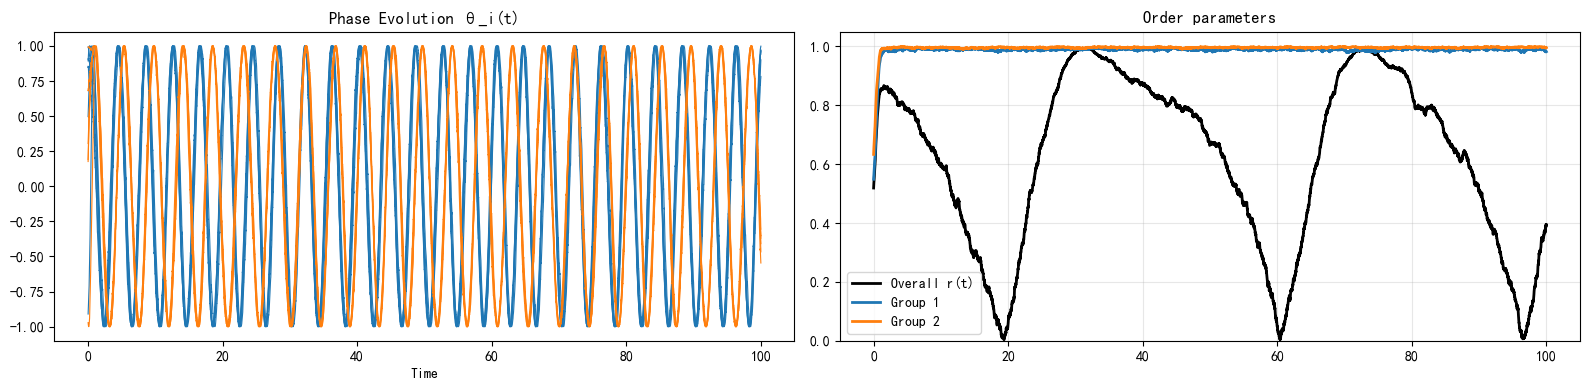

In [30]:
N=12
X_embed, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=2,  # 团数
    K_intra=5,   # 团内耦合
    K_inter=0.1,   # 团间耦合
    noise=0.01,
    T=100
)

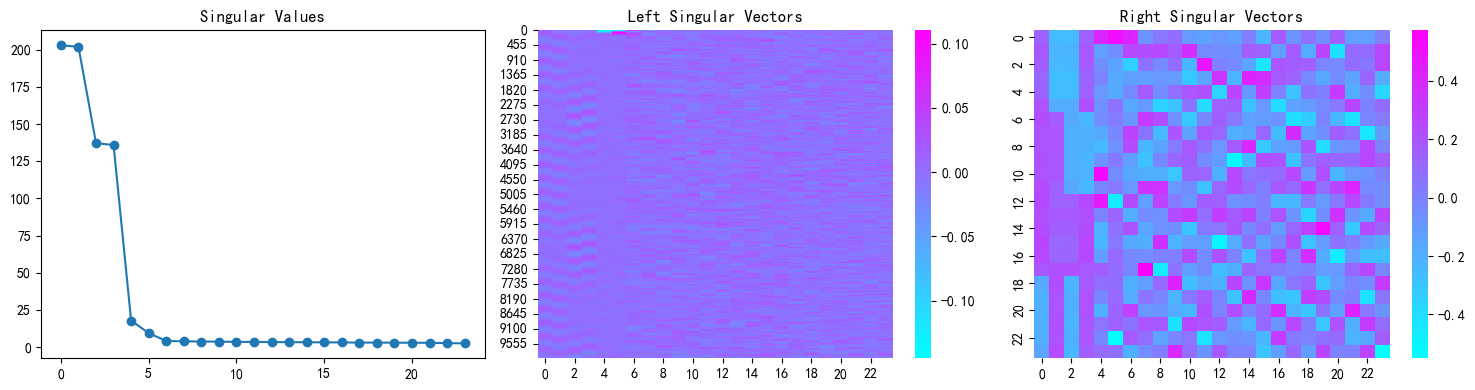

In [31]:
tsvd = pykoop.Tsvd() #truncation='rank',truncation_param=8
tsvd.fit(X_embed)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(tsvd.singular_values_, marker='o')
ax[0].set_title('Singular Values')

sns.heatmap(tsvd.left_singular_vectors_, cmap='cool', ax=ax[1])
ax[1].set_title('Left Singular Vectors')

sns.heatmap(tsvd.right_singular_vectors_, cmap='cool', ax=ax[2])
ax[2].set_title('Right Singular Vectors')

plt.tight_layout()
plt.show()

# 时间延时 han

In [32]:
#延迟嵌入，Hankel
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('delay', pykoop.DelayLiftingFn(n_delays_state=2)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='unknown_noise')),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='rank',truncation_param=4)),
)
# Fit the pipeline
kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error

0.08357105909849365

In [33]:
M = len(X_embed)-1
W = np.ones(M) / M
X = X_embed[:-1]
Y = X_embed[1:]
XH = kp.transform(X)
YH = kp.transform(Y)
G, A, L = compute_koopman_matrices(XH, W, YH)

In [34]:
K1 = kp.regressor_.coef_
print(K1.shape)
U1,S1,V1 = np.linalg.svd(K1)
print(S1)
U1_abs = np.abs(U1)

(72, 72)
[1.17102431e+00 1.16880196e+00 1.16468991e+00 1.16231499e+00
 1.15901439e+00 1.15618171e+00 1.15147883e+00 1.14847446e+00
 1.14825727e+00 1.14396472e+00 1.14200400e+00 1.14045467e+00
 1.13872249e+00 1.13651100e+00 1.13606369e+00 1.13262958e+00
 1.12878880e+00 1.12795005e+00 1.12705604e+00 1.12209344e+00
 1.12060167e+00 1.11721040e+00 1.11556060e+00 1.11463331e+00
 5.36702365e-01 5.35743582e-01 5.33108637e-01 5.31981201e-01
 5.29738274e-01 5.28055216e-01 5.26413026e-01 5.24553418e-01
 5.22758921e-01 5.22288571e-01 5.20540826e-01 5.18419816e-01
 5.17317812e-01 5.16152275e-01 5.13126177e-01 5.10121078e-01
 5.08960841e-01 5.06607780e-01 5.05628018e-01 5.04263581e-01
 5.02578655e-01 5.00372876e-01 4.98202079e-01 4.90767758e-01
 4.02366253e-02 3.91150429e-02 3.60617288e-02 3.41413745e-02
 2.98389818e-02 2.87799783e-02 2.71245503e-02 2.49939282e-02
 2.27628765e-02 2.24951342e-02 2.00767569e-02 1.80623219e-02
 1.64010488e-02 1.45988704e-02 1.32095574e-02 1.24133371e-02
 1.04892193e-02

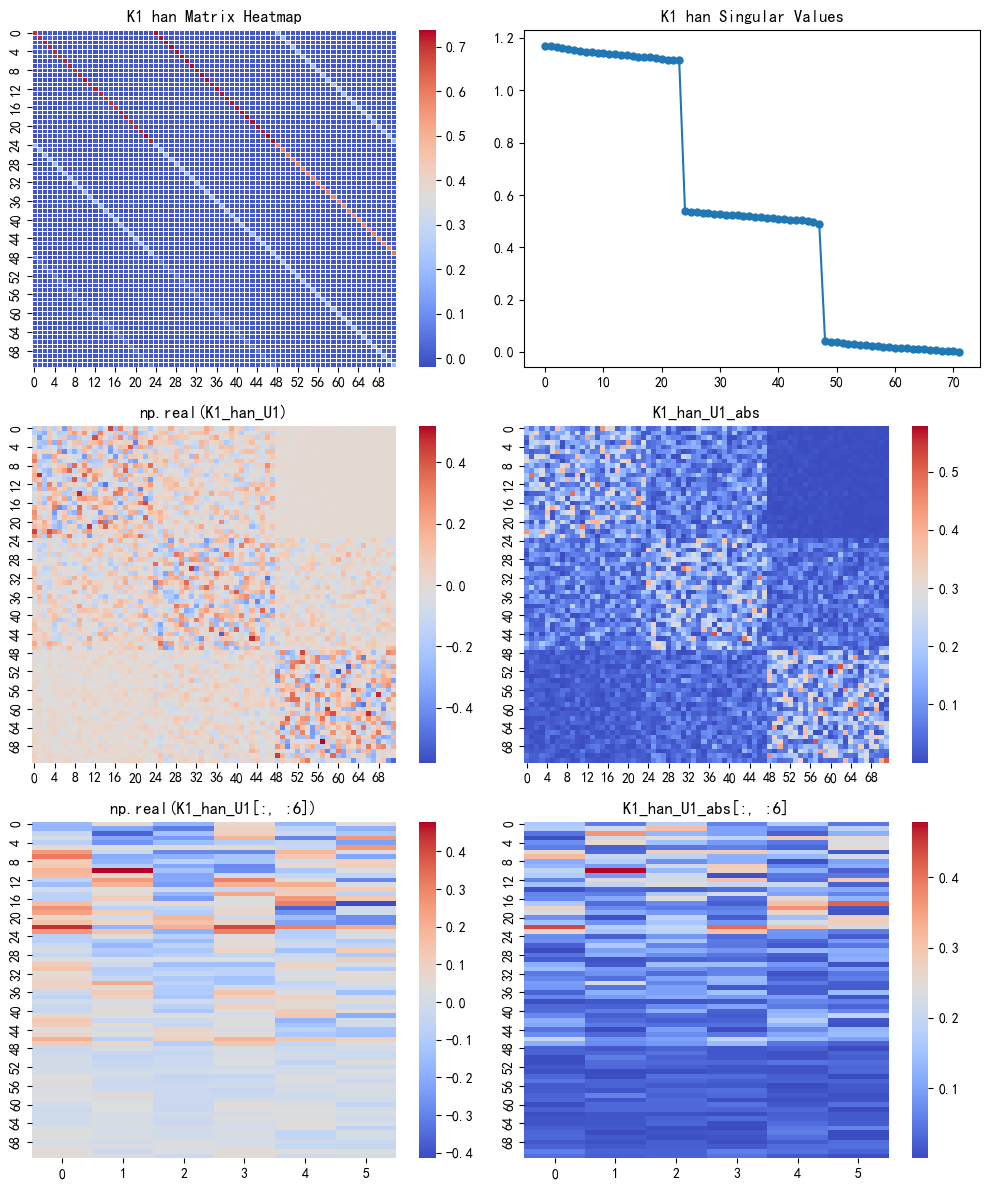

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()         

sns.heatmap(K1, ax=axes[0], cmap='coolwarm', linewidths=0.5)
axes[0].set_title('K1 han Matrix Heatmap')

axes[1].plot(S1, marker='o', markersize=5)
axes[1].set_title('K1 han Singular Values')

sns.heatmap(np.real(U1), ax=axes[2], cmap='coolwarm')
axes[2].set_title('np.real(K1_han_U1)')

sns.heatmap(np.abs(U1), ax=axes[3], cmap='coolwarm')
axes[3].set_title('K1_han_U1_abs')

sns.heatmap(np.real(U1[:, :6]), ax=axes[4], cmap='coolwarm')
axes[4].set_title('np.real(K1_han_U1[:, :6])')

sns.heatmap(np.abs(U1[:, :6]), ax=axes[5], cmap='coolwarm')
axes[5].set_title('K1_han_U1_abs[:, :6]')

plt.tight_layout()
plt.show()

In [36]:
eigenvalues1, eigenvectors1 = eig(K1)

总特征值数量: 72
可靠特征值数量 (res <= 0.01): (4, [0, 1, 2, 3])
虚假特征值数量 (res > 0.01): 68


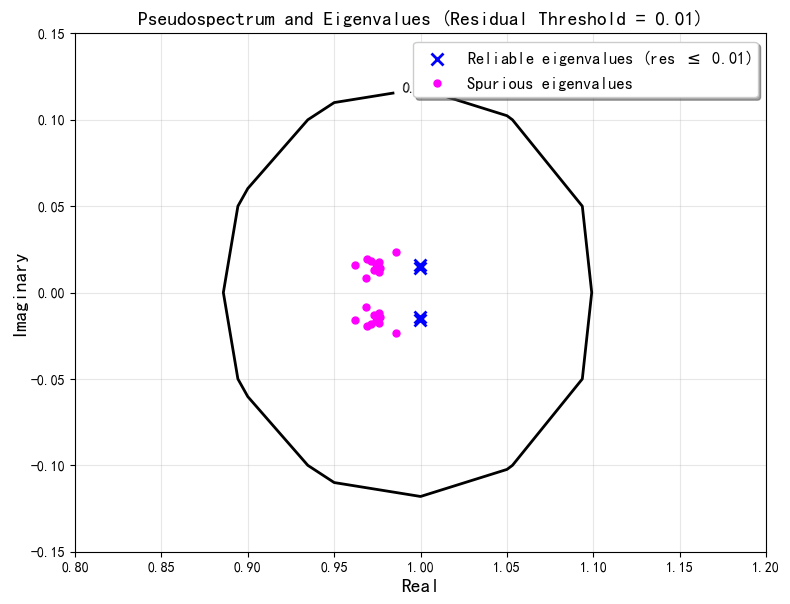

In [37]:
residuals1, reliable_indices1 = plot_pseudospectra(G, A, L, eigenvalues1, eigenvectors1, residual_threshold=0.01, fixed_range=(0.8,1.2,-0.15,0.15))

In [38]:
p_steps = 1000
X_test = X_embed[:p_steps,:]

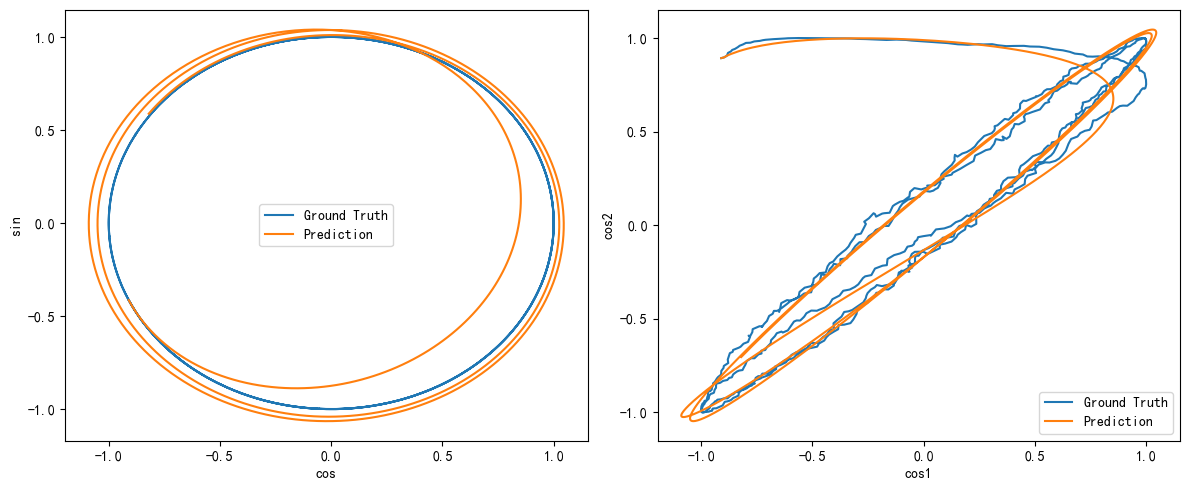

In [39]:
pred = kp.predict_trajectory(X_test,None)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], X_test[:, N], label='Ground Truth')
plt.plot(pred[:, 0], pred[:, N], label='Prediction')
plt.xlabel('cos')
plt.ylabel('sin')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(X_test[:, 0], X_test[:, 1], label='Ground Truth')
plt.plot(pred[:, 0], pred[:, 1], label='Prediction')
plt.xlabel('cos1')
plt.ylabel('cos2')
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
K2 = np.linalg.pinv(G) @ A
print(K2.shape)
U2,S2,V2 = np.linalg.svd(K2)
print(S2)
U2_abs = np.abs(U2)

(72, 72)
[1.45073748e+00 1.44414795e+00 1.44169150e+00 1.43246844e+00
 1.42810173e+00 1.42658642e+00 1.42154516e+00 1.41528137e+00
 1.41212820e+00 1.41114430e+00 1.41036132e+00 1.40417668e+00
 1.39961203e+00 1.39697978e+00 1.39502804e+00 1.38878443e+00
 1.38466735e+00 1.38159585e+00 1.37984664e+00 1.37776895e+00
 1.36891322e+00 1.36749520e+00 1.36004102e+00 1.35654030e+00
 1.00008569e+00 1.00008354e+00 1.00004051e+00 1.00003388e+00
 1.00002757e+00 1.00002599e+00 1.00002135e+00 1.00001237e+00
 1.00000943e+00 1.00000710e+00 1.00000483e+00 1.00000055e+00
 9.99999657e-01 9.99997080e-01 9.99995060e-01 9.99991479e-01
 9.99989087e-01 9.99981080e-01 9.99976817e-01 9.99971164e-01
 9.99966217e-01 9.99952267e-01 9.99921241e-01 9.99914804e-01
 6.37404852e-02 6.26865445e-02 5.64084701e-02 5.42502472e-02
 4.73849603e-02 4.57599064e-02 4.32293814e-02 3.92277155e-02
 3.64760421e-02 3.55570230e-02 3.19932895e-02 2.85946726e-02
 2.61000419e-02 2.28259660e-02 2.10170822e-02 1.96481730e-02
 1.66740776e-02

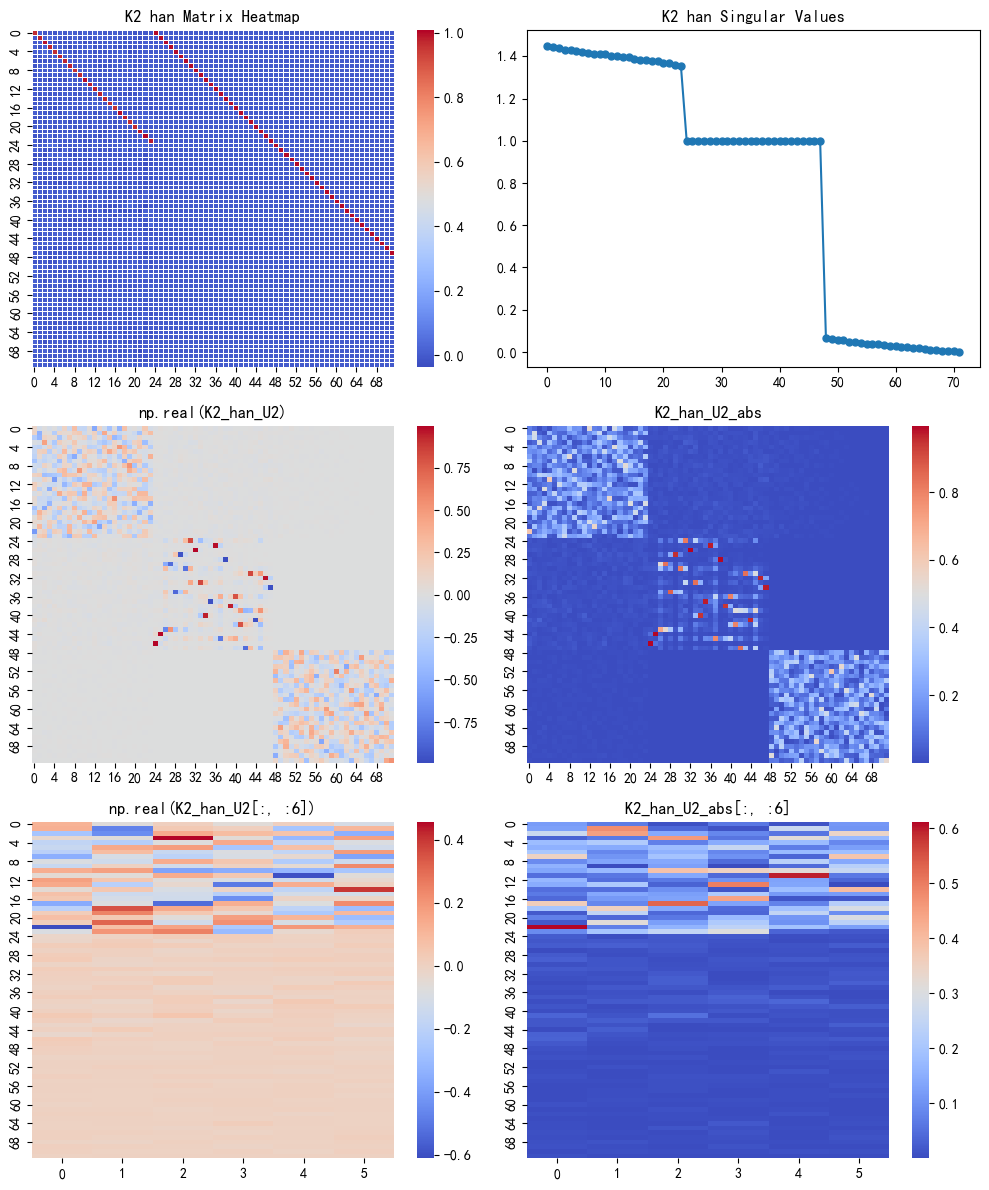

In [41]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()         

sns.heatmap(K2, ax=axes[0], cmap='coolwarm', linewidths=0.5)
axes[0].set_title('K2 han Matrix Heatmap')

axes[1].plot(S2, marker='o', markersize=5)
axes[1].set_title('K2 han Singular Values')

sns.heatmap(np.real(U2), ax=axes[2], cmap='coolwarm')
axes[2].set_title('np.real(K2_han_U2)')

sns.heatmap(np.abs(U2), ax=axes[3], cmap='coolwarm')
axes[3].set_title('K2_han_U2_abs')

sns.heatmap(np.real(U2[:, :6]), ax=axes[4], cmap='coolwarm')
axes[4].set_title('np.real(K2_han_U2[:, :6])')

sns.heatmap(np.abs(U2[:, :6]), ax=axes[5], cmap='coolwarm')
axes[5].set_title('K2_han_U2_abs[:, :6]')

plt.tight_layout()
plt.show()

In [42]:
eigenvalues2, eigenvectors2 = eig(K2)

总特征值数量: 72
可靠特征值数量 (res <= 0.01): (4, [48, 49, 50, 51])
虚假特征值数量 (res > 0.01): 68


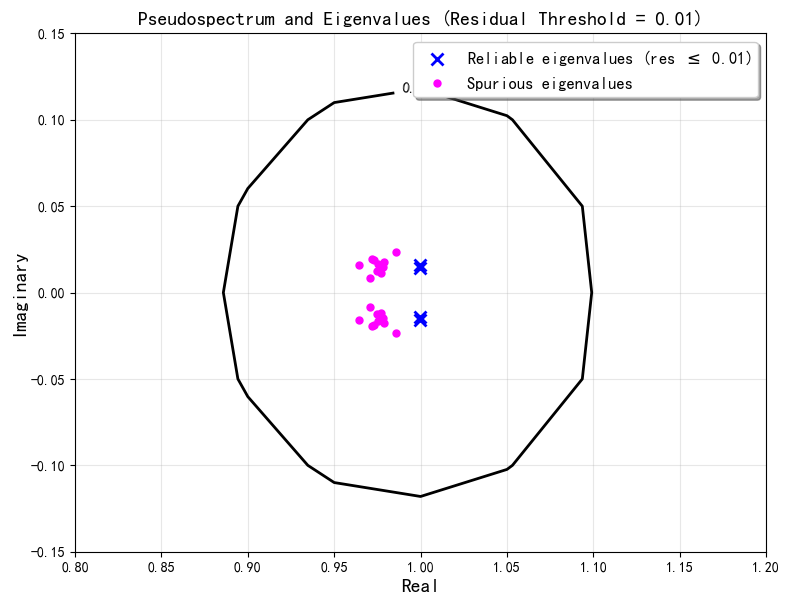

In [43]:
residuals2, reliable_indices2 = plot_pseudospectra(G, A, L, eigenvalues2, eigenvectors2, residual_threshold=0.01, fixed_range=(0.8,1.2,-0.15,0.15))

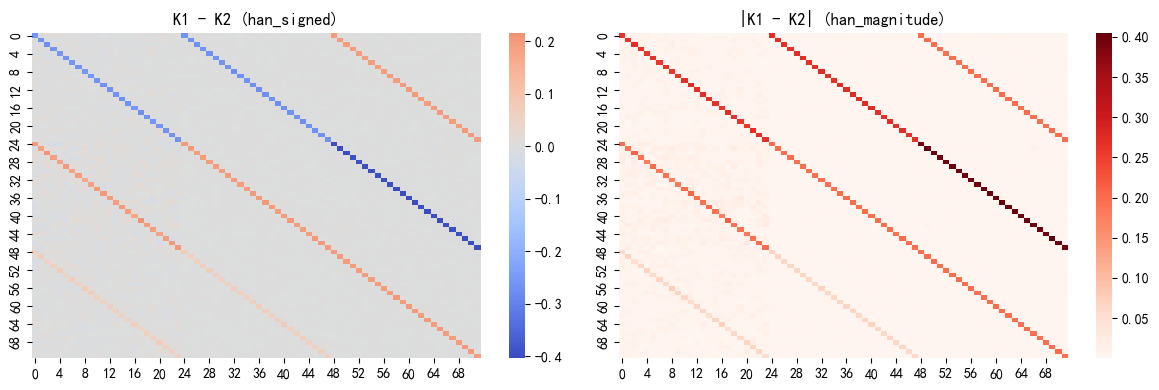

In [44]:
diff = K1 - K2         
diff_abs = np.abs(diff)  

# 画两幅图：左→差值（带符号），右→绝对差
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(diff, cmap='coolwarm', center=0, ax=ax[0],
            annot=False, linewidths=0)
ax[0].set_title('K1 - K2 (han_signed)')

sns.heatmap(diff_abs, cmap='Reds', ax=ax[1],
            annot=False, linewidths=0)
ax[1].set_title('|K1 - K2| (han_magnitude)')

plt.tight_layout()
plt.show()

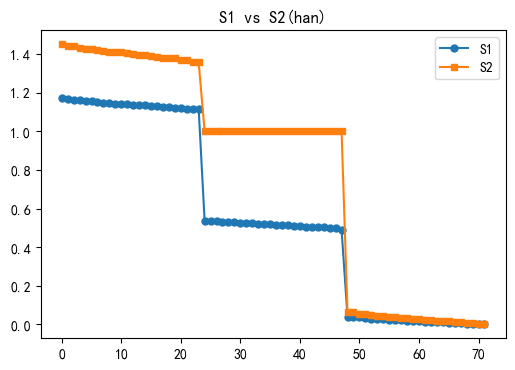

In [45]:
plt.figure(figsize=(6, 4))          
plt.plot(S1,  marker='o', markersize=5, label='S1')
plt.plot(S2, marker='s', markersize=5, label='S2')
plt.title('S1 vs S2(han)')
plt.legend()
plt.show()

In [52]:
residuals1 = np.array(residuals1)
residuals2 = np.array(residuals2)

In [53]:
res_dict = {}
methods = ["han_K1", "han_K2"]
res_dict["han_K1"] = residuals1
res_dict["han_K2"] = residuals2

print("数据存储完成，字典结构：")
for method, data in res_dict.items():
    print(f"{method}: 共{len(data)}个误差值，均值={data.mean():.4f}，标准差={data.std():.4f}")

数据存储完成，字典结构：
han_K1: 共72个误差值，均值=0.6950，标准差=0.4064
han_K2: 共72个误差值，均值=0.7109，标准差=0.3880


In [54]:
print("\n=== 详细统计分析 ===")
stats_df = pd.DataFrame()
for method, data in res_dict.items():
    stats_df[method] = [
        len(data),                  # 数据量
        data.mean(),                # 均值（误差大小）
        data.std(),                 # 标准差（稳定性）
        data.min(),                 # 最小
        data.max(),                 # 最大
        np.median(data),            # 中位数（抗异常值）
        stats.skew(data),           # 偏度（分布对称性）
        stats.kurtosis(data)        # 峰度（分布陡峭程度）
    ]
stats_df.index = ["数据量", "均值", "标准差", "最小值", "最大值", "中位数", "偏度", "峰度"]
print(stats_df.round(4))


=== 详细统计分析 ===
      han_K1   han_K2
数据量  72.0000  72.0000
均值    0.6950   0.7109
标准差   0.4064   0.3880
最小值   0.0034   0.0047
最大值   0.9995   0.9962
中位数   0.9687   0.9755
偏度   -0.7306  -0.7609
峰度   -1.4209  -1.3348


In [55]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False    # 支持负号

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


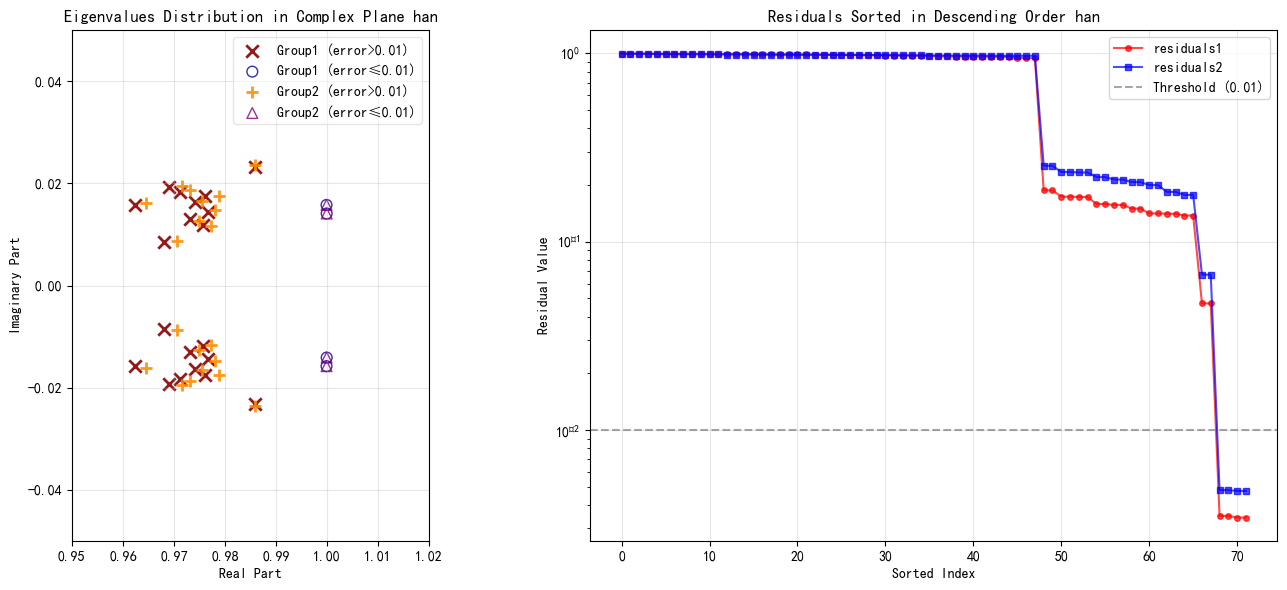

In [56]:
fig = plt.figure(figsize=(14, 6))
gs = plt.GridSpec(1, 2, width_ratios=[1, 1])  # 第一个子图稍宽一些
ax1 = plt.subplot(gs[0])  # 第一个子图（复平面）
ax2 = plt.subplot(gs[1])  # 第二个子图（残差图）

# 第一个子图：复平面上的特征值分布
threshold = 0.01  # 误差阈值

# 处理第一组特征值
real1 = np.real(eigenvalues1)
imag1 = np.imag(eigenvalues1)
large_residuals_mask1 = residuals1 > threshold
small_residuals_mask1 = residuals1 <= threshold

# 处理第二组特征值
real2 = np.real(eigenvalues2)
imag2 = np.imag(eigenvalues2)
large_residuals_mask2 = residuals2 > threshold
small_residuals_mask2 = residuals2 <= threshold

# 绘制特征值
ax1.scatter(real1[large_residuals_mask1], imag1[large_residuals_mask1], 
           marker='x', s=80, color='darkred', alpha=0.9, linewidth=2, 
           label='Group1 (error>0.01)')
ax1.scatter(real1[small_residuals_mask1], imag1[small_residuals_mask1], 
           marker='o', s=60, facecolors='none',color='darkblue', alpha=0.8, 
           label='Group1 (error≤0.01)')

ax1.scatter(real2[large_residuals_mask2], imag2[large_residuals_mask2], 
           marker='+', s=80, color='darkorange', alpha=0.9, linewidth=2,
           label='Group2 (error>0.01)')
ax1.scatter(real2[small_residuals_mask2], imag2[small_residuals_mask2], 
           marker='^', s=60, facecolors='none',color='purple', alpha=0.8,
           label='Group2 (error≤0.01)')

# 设置第一个子图
ax1.set_xlabel('Real Part')
ax1.set_ylabel('Imaginary Part')
ax1.set_title('Eigenvalues Distribution in Complex Plane han')
ax1.legend(framealpha=0.5)
ax1.grid(True, alpha=0.3)

# 设置坐标轴范围为正方形
ax1.set_xlim(0.95, 1.02)
ax1.set_ylim(-0.05, 0.05)
ax1.set_aspect('equal')  # 确保1:1比例

# 第二个子图：残差排序折线图
# 对残差从大到小排序
sorted_residuals1 = np.sort(residuals1)[::-1]  # 降序
sorted_residuals2 = np.sort(residuals2)[::-1]  # 降序

# 绘制排序后的残差
ax2.plot(sorted_residuals1, marker='o', linestyle='-', markersize=4, 
         color='red', alpha=0.7, label='residuals1')
ax2.plot(sorted_residuals2, marker='s', linestyle='-', markersize=4, 
         color='blue', alpha=0.7, label='residuals2')

# 添加阈值线
ax2.axhline(y=threshold, color='gray', linestyle='--', alpha=0.7, 
            label=f'Threshold ({threshold})')

# 设置第二个子图
ax2.set_xlabel('Sorted Index')
ax2.set_ylabel('Residual Value')
ax2.set_title('Residuals Sorted in Descending Order han')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# 调整布局
plt.tight_layout()
plt.show()